# Sea Surface Temperature — NEMO GYRE

Analyse SST (`sosstsst`) from the 2-year GYRE simulation.
- Mean SST field
- SST temporal evolution
- Meridional SST gradient

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

OUTPUT_DIR = Path("../output")
ds = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_T_0000.nc", decode_times=False
)
mask = xr.open_dataset(OUTPUT_DIR / "mesh_mask.nc")
tmask_sfc = mask["tmask"].isel(time_counter=0, nav_lev=0).values  # (y, x)

# Exclude outermost ring (boundary condition cells)
interior = tmask_sfc.copy()
interior[0, :] = 0
interior[-1, :] = 0
interior[:, 0] = 0
interior[:, -1] = 0

sst = ds["sosstsst"]
sst

<xarray.DataArray 'sosstsst' (time_counter: 72, y: 22, x: 32)> Size: 203kB
[50688 values with dtype=float32]
Coordinates:
  * time_counter  (time_counter) float64 576B 4.32e+05 1.296e+06 ... 6.178e+07
    nav_lon       (y, x) float32 3kB ...
    nav_lat       (y, x) float32 3kB ...
Dimensions without coordinates: y, x
Attributes:
    units:               C
    standard_name:       Sea Surface temperature
    long_name:           Sea Surface temperature
    online_operation:    ave(x)
    interval_operation:  14400.0
    interval_write:      864000.0

## Time-mean SST

Average SST over the full 2-year run. Expect a north-south gradient
with warm subtropical gyre and cool subpolar gyre, plus western
boundary current signature.

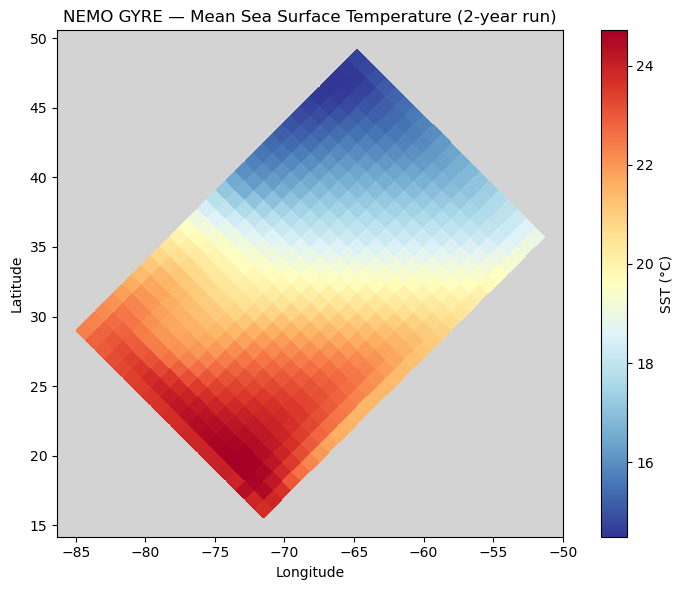

In [2]:
sst_mean = sst.mean("time_counter")
sst_masked = np.where(interior, sst_mean.values, np.nan)

fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(
    ds.nav_lon.values, ds.nav_lat.values, sst_masked,
    shading="auto", cmap="RdYlBu_r",
)
fig.colorbar(pcm, ax=ax, label="SST (\u00b0C)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Mean Sea Surface Temperature (2-year run)")
ax.set_facecolor("lightgrey")
ax.set_aspect("equal")
fig.tight_layout()

## SST temporal evolution

Domain-mean SST over time — tracks overall warming/cooling trends
during spin-up.

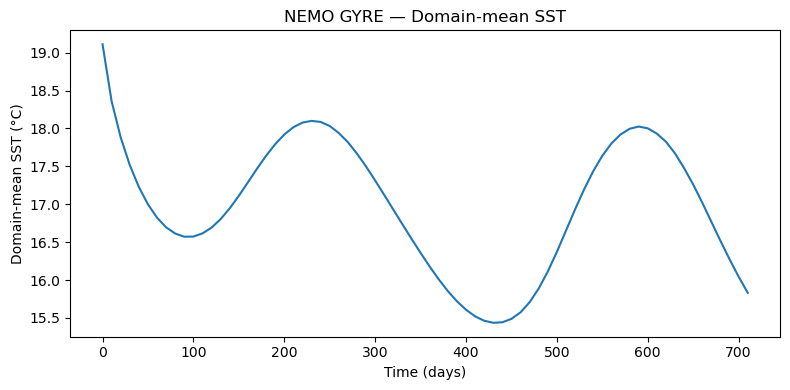

In [3]:
sst_domain_mean = sst.mean(dim=["x", "y"])
time_days = (ds.time_counter.values - ds.time_counter.values[0]) / 86400.0

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_days, sst_domain_mean.values)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Domain-mean SST (\u00b0C)")
ax.set_title("NEMO GYRE — Domain-mean SST")
fig.tight_layout()

## Meridional SST gradient

Zonally averaged SST as a function of latitude — shows the
subtropical-to-subpolar temperature contrast.

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_64105/3624465130.py:6: RuntimeWarning: Mean of empty slice
  sst_zonal_mean = np.nanmean(sst_time_mean_masked, axis=1)


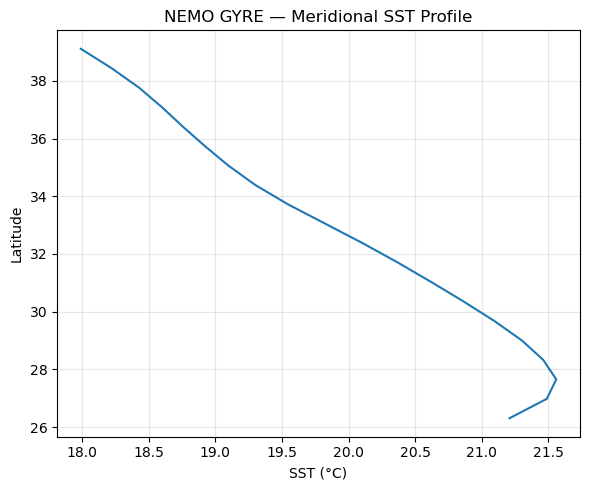

In [4]:
# Mask boundary cells before zonal averaging
sst_time_mean = sst.mean("time_counter").values
sst_time_mean_masked = np.where(interior, sst_time_mean, np.nan)

# Zonal mean ignoring masked cells
sst_zonal_mean = np.nanmean(sst_time_mean_masked, axis=1)
lat = ds.nav_lat.values[:, ds.nav_lat.shape[1] // 2]  # mid-column latitudes

# Drop rows that are fully masked
valid = ~np.isnan(sst_zonal_mean)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(sst_zonal_mean[valid], lat[valid])
ax.set_xlabel("SST (\u00b0C)")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Meridional SST Profile")
ax.grid(True, alpha=0.3)
fig.tight_layout()